In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ELECTRON = False
G_COORD = False
L_COORD = False

In [6]:
VIEW_BOUND = (-500, 500)
AIR_BOUND = (-500, -499)
BONE_BOUND = (255, 256)
if ELECTRON:
    VIEW_BOUND = (0.5, 1.5)
    AIR_BOUND = (0.5, 0.5009)
    BONE_BOUND = (1.2, 1.2009)    

In [7]:
config = {
    # lamda weight
    "Adv_lamda": 1,
    "Cyc_lamda": 10,
    "Corr_lamda": 20,
    "Smooth_lamda": 10,
    "Recon_kl_lamda": 0.01,

    "n_epoch": 80,        # starting epoch
    "batchSize": 1,               # size of the batches
    "lr": 0.0001,                   # initial learning rate
    "decay_epoch": 20,            # epoch to start linearly decaying the learning rate to 0
    "input_nc": 1,         
    "output_nc": 1,                         
    "n_cpu": 1,
    "size": 256,
    "cuda": True,
    
    ### Unit
    "gen": {
      "dim": 64,                     # number of filters in the bottommost layer
      "activ": "relu",                 # activation function [relu/lrelu/prelu/selu/tanh]
      "n_downsample": 2,             # number of downsampling layers in content encoder
      "n_res": 4,                    # number of residual blocks in content encoder/decoder
      "pad_type": "reflect",           # padding type [zero/reflect]
    },
    "dis": {
      "dim": 64,                     # number of filters in the bottommost layer
      "norm": "none",                   # normalization layer [none/bn/in/ln]
      "activ": "lrelu",                # activation function [relu/lrelu/prelu/selu/tanh]
      "n_layer": 4,                  # number of layers in D
      "gan_type": "lsgan",             # GAN loss [lsgan/nsgan]
      "num_scales": 3,               # number of scales
      "pad_type": "reflect",           # padding type [zero/reflect]
    },
    
    "input_dim_a": 1,                              # number of image channels [1/3]
    "input_dim_b": 1,                              # number of image channels [1/3]
}

# Epochs

In [8]:
from codes.losses import SSIMLoss, MAELoss, KLDivergence
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from torch.autograd import Variable

In [9]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [10]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [11]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [12]:
def smooothing_loss(y_pred):
    dy = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])
    dx = torch.abs(y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1])

    dx = dx*dx
    dy = dy*dy
    d = torch.mean(dx) + torch.mean(dy)
    grad = d 
    return d

In [13]:
def train_d_epoch(netG_A2B, netG_B2A,
                    netD_B, optimizer_D_B,
                    dataloader, device):

    # change mode to train and move to current device
    netG_A2B = netG_A2B.eval().to(device)
    netG_B2A = netG_B2A.eval().to(device)
    netD_B = netD_B.train().to(device)
    
    total_lossD = 0

    set_requires_grad(netD_B, True)
    set_requires_grad(netG_A2B, False)
    set_requires_grad(netG_B2A, False)
    
    for index, data in tqdm(enumerate(dataloader)):
        
        x, y, *_ = data
 
        B, C, H, W = x.size()
        x = x.to(device)
        y = y.to(device)
        
        ###### Discriminator ######
        optimizer_D.zero_grad()
        h_a, n_a = netG_A2B.encode(x.float())
        h_b, n_b = netG_B2A.encode(y.float())
        
        # decode (cross domain)
        x_ab = netG_B2A.decode(h_a + n_a)
        # D loss
        loss_D_B = netD_B.calc_dis_loss(x_ab.detach(), y.float())
        
        loss_dis_total = config['Adv_lamda'] * loss_D_B
        loss_dis_total.backward()
        optimizer_D.step()

        total_lossD += loss_dis_total.item()
        
    return  total_lossD/(index+1)

In [14]:
def train_g_epoch(netG_A2B, netG_B2A, optimizer_G,
                    netD_B, dataloader, device):

    # change mode to train and move to current device
    netG_A2B = netG_A2B.train().to(device)
    netG_B2A = netG_B2A.train().to(device)
    netD_B = netD_B.eval().to(device)
    
    total_lossG = 0

    set_requires_grad(netG_A2B, True)
    set_requires_grad(netG_B2A, True)
    set_requires_grad(netD_B, False)
    
    for index, data in tqdm(enumerate(dataloader)):
        
        x, y, *_ = data
 
        B, C, H, W = x.size()
        x = x.to(device)
        y = y.to(device)

        optimizer_G.zero_grad()
        
        # GAN loss # encode
        h_a, n_a = netG_A2B.encode(x.float())
        h_b, n_b = netG_B2A.encode(y.float())
        # decode (within domain)
        x_a_recon = netG_A2B.decode(h_a + n_a)
        x_b_recon = netG_B2A.decode(h_b + n_b)
        # decode (cross domain)
        x_ba = netG_A2B.decode(h_b + n_b)
        x_ab = netG_B2A.decode(h_a + n_a)
        # encode again
        h_b_recon, n_b_recon = netG_A2B.encode(x_ba)
        h_a_recon, n_a_recon = netG_B2A.encode(x_ab)
        # decode again (if needed)
        x_aba = netG_A2B.decode(h_a_recon + n_a_recon)
        x_bab = netG_B2A.decode(h_b_recon + n_b_recon)

        # reconstruction loss
        loss_gen_recon_x_a = nn.L1Loss()(x_a_recon, x.float())
        loss_gen_recon_x_b = nn.L1Loss()(x_b_recon, y.float())
        loss_gen_recon_kl_a = KLDivergence()(h_a)
        loss_gen_recon_kl_b = KLDivergence()(h_b)
        loss_gen_cyc_x_a = nn.L1Loss()(x_aba, x.float())
        loss_gen_recon_kl_cyc_aba = KLDivergence()(h_a_recon)

        # GAN loss
        loss_gen_adv_b = netD_B.calc_gen_loss(x_ab)
        
        # Total loss
        loss_G = (
            loss_gen_adv_b * config['Adv_lamda']
            + loss_gen_recon_x_a * config['Cyc_lamda']
            + loss_gen_recon_x_b * config['Cyc_lamda']
            + loss_gen_recon_kl_a * config['Recon_kl_lamda']
            + loss_gen_recon_kl_b * config['Recon_kl_lamda']
            + loss_gen_cyc_x_a * config['Cyc_lamda']
            + loss_gen_recon_kl_cyc_aba * config['Recon_kl_lamda']
        )
        
        loss_G.backward()
        optimizer_G.step()
                        
        total_lossG += loss_G.item()
        
    return  total_lossG/(index+1)

In [15]:
@torch.no_grad()
def eval_epoch(netG_A2B, netG_B2A, netD_B, dataloader, device):
  
    # change mode to train and move to current device
    netG_A2B = netG_A2B.eval().to(device)
    netG_B2A = netG_B2A.eval().to(device)
    netD_B = netD_B.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []

    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data
        
        B, C, H, W = x.size()
        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        h_A, _ = netG_A2B.encode(x.float())
        fake_B = netG_B2A.decode(h_A)
    
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################

        # main
        _ssim = ssim(y.float(), fake_B, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(fake_B, y.float(), 1.0)
        _snr = SNR()(fake_B, y.float())
        _mae = MAELoss()(fake_B.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = VIEW_BOUND[0]
        _max = VIEW_BOUND[1]
        air_window = AIR_BOUND
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(fake_B.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = BONE_BOUND
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(fake_B.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        for b in range(x.size()[0]):
            cont = ContourEval()(fake_B[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_)

# Data

In [16]:
from codes.dataset import DicomsDataset
import codes.augmentation as aug

In [17]:
pelvic_train_case_path = 'raw/train/*_*'
pelvic_train_id_path = 'raw/train_id/*_*'
pelvic_test_case_path = 'raw/test/*_*'

In [18]:
trainset = DicomsDataset(pelvic_train_case_path, 
                   intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(),
                  identity=False, electron=ELECTRON, position="pelvic", g_coord=G_COORD, l_coord=L_COORD)

In [19]:
trainset_id = DicomsDataset(pelvic_train_id_path, 
                   intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(),
                  identity=False, electron=ELECTRON, position="pelvic", g_coord=G_COORD, l_coord=L_COORD)

In [20]:
testset = DicomsDataset(pelvic_test_case_path, geometry_aug=aug.get_validation_augmentation(), 
                 identity=False, electron=ELECTRON, position="pelvic", g_coord=G_COORD, l_coord=L_COORD)

In [21]:
trainset = ConcatDataset([trainset, trainset_id])

In [22]:
len(trainset), len(testset)

(1344, 191)

In [23]:
x, y, *_ = trainset[20]

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

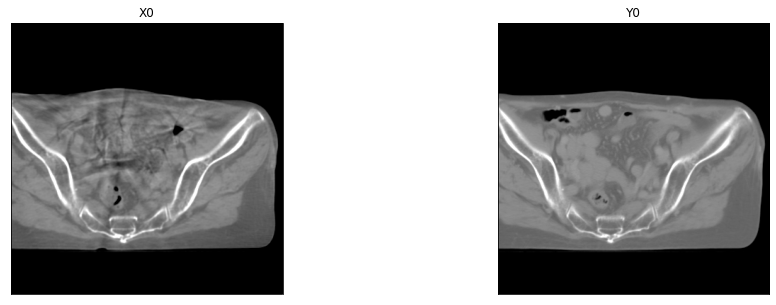

In [25]:
visualize(
    x0 = x[0].squeeze(),
    y0 = y[0].squeeze())

In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=config["batchSize"], shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

# Model Define

In [27]:
from codes.RegGAN.Unit import *

In [28]:
netG_A2B = VAEGen(config["input_nc"], config["gen"]) # auto-encoder for domain a
netG_B2A = VAEGen(config["input_dim_b"], config["gen"])  # auto-encoder for domain b
netD_B = MsImageDis(config["input_dim_b"], config["dis"])  # discriminator for domain b
optimizer_G = torch.optim.Adam(list(netG_A2B.parameters())+list(netG_B2A.parameters()), lr=config["lr"], betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(netD_B.parameters(), lr=config["lr"], betas=(0.5, 0.999))

# Training

In [29]:
import wandb

wandb.init(project="cbct_unit", config=config)

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [30]:
wandb.watch(netG_A2B)
wandb.watch(netG_B2A)
wandb.watch(netD_B)

max_score = 0

for epoch in range(config["n_epoch"]):
        
        loss_D = train_d_epoch(netG_A2B, netG_B2A,
                                                            netD_B, optimizer_D,
                                                            trainloader, device)
        loss_G = train_g_epoch(netG_A2B, netG_B2A, optimizer_G,
                                                                        netD_B, trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train = eval_epoch(netG_A2B, netG_B2A, netD_B, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test = eval_epoch(netG_A2B, netG_B2A, netD_B, testloader, device)

        wandb.log({
            "loss D": loss_D,
            "loss G": loss_G,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
        })
        
        
        if score_air_test +  score_bone_test + score_psnr_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_psnr_test
            checkpoint = {
                "netG_A2B": netG_A2B.state_dict(),
                "netG_B2A": netG_B2A.state_dict(),
                "optimizer_G": optimizer_G.state_dict(),
                "netD_B": netD_B.state_dict(),
                "optimizer_D": optimizer_D.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))
            print("Epoch={}".format(epoch))

1344it [03:12,  6.98it/s]
1344it [22:54,  1.02s/it]
1344it [01:56, 11.58it/s]
191it [00:16, 11.30it/s]


Epoch=0


1344it [03:11,  7.01it/s]
1344it [23:25,  1.05s/it]
1344it [01:58, 11.36it/s]
191it [00:16, 11.28it/s]
1344it [03:05,  7.23it/s]
1344it [22:59,  1.03s/it]
1344it [01:58, 11.35it/s]
191it [00:16, 11.26it/s]
1344it [03:11,  7.01it/s]
1344it [22:51,  1.02s/it]
1344it [01:58, 11.38it/s]
191it [00:16, 11.26it/s]


Epoch=3


1344it [03:11,  7.03it/s]
1344it [23:12,  1.04s/it]
1344it [01:52, 11.91it/s]
191it [00:16, 11.42it/s]
1344it [03:07,  7.18it/s]
1344it [23:26,  1.05s/it]
1344it [01:57, 11.45it/s]
191it [00:16, 11.29it/s]
1344it [03:11,  7.01it/s]
1344it [22:52,  1.02s/it]
1344it [01:58, 11.36it/s]
191it [00:16, 11.42it/s]
1344it [03:11,  7.01it/s]
1344it [22:52,  1.02s/it]
1344it [01:58, 11.35it/s]
191it [00:17, 11.22it/s]
1344it [03:11,  7.02it/s]
1344it [23:30,  1.05s/it]
1344it [01:58, 11.37it/s]
191it [00:16, 11.29it/s]
1344it [02:52,  7.79it/s]
1344it [23:18,  1.04s/it]
1344it [01:58, 11.36it/s]
191it [00:17, 11.22it/s]
1344it [03:11,  7.03it/s]
1344it [22:51,  1.02s/it]
1344it [01:58, 11.35it/s]
191it [00:16, 11.28it/s]
1344it [03:11,  7.01it/s]
1344it [23:01,  1.03s/it]
1344it [01:55, 11.60it/s]
191it [00:16, 11.43it/s]
1344it [03:09,  7.08it/s]
1344it [23:26,  1.05s/it]
1344it [01:58, 11.36it/s]
191it [00:16, 11.28it/s]
1344it [03:11,  7.03it/s]
1344it [22:50,  1.02s/it]
1344it [01:58, 11.36i